Very messy implementation of https://arxiv.org/pdf/2410.10103

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import diffrax
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

from src.generator import coupled_rossler
from src.koopman import random_fourier_features, dynamic_mode_decomposition, compute_causal_loss

## Generate dynamics 
In particular, trying to replicate Fig 1b.
Since the IC is not defned in the paper, tried to approximate i.e., eye-ball from the subfigure

#### Specify parameters, ICs, timestepping

In [3]:
# Time span
t0, t1 = 0.0, 10.0
dt = 0.01
steps = int((t1 - t0) / dt)

# Parameters
phi1, phi2 = 1.0, 1.0  # Frequencies
a, b, d = 0.2, 0.2, 5.7  # Rössler parameters

# Initial condition (eye-ball from the paper)
initial_state = jnp.array([1.0, -2.0, 0.0, -1.0, 1.0, 0.0])

# Coupling coefficients 
# (causal direction: Omega 2 --> Omega 1; but NOT Omega 1 --> Omega 2)
c2 = 0

### Integrate forward

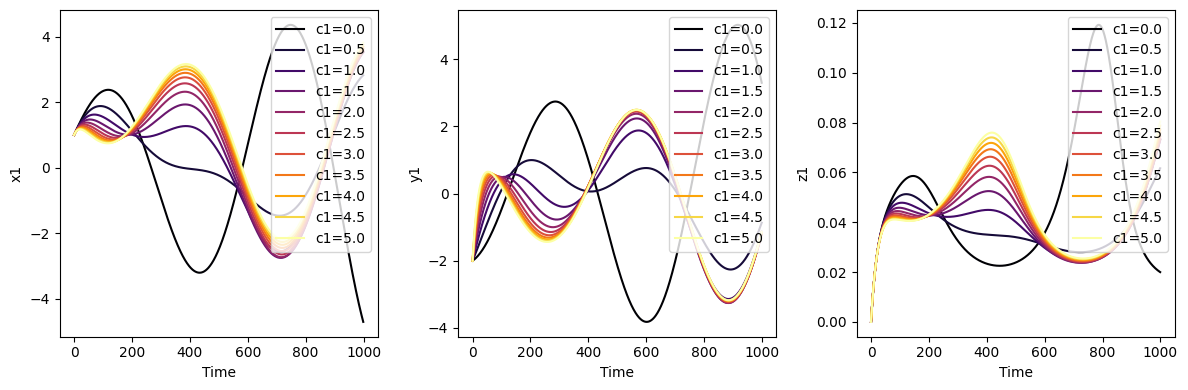

In [4]:
# Integration
solver = diffrax.Dopri5()  # Runge-Kutta solver

# Create figure
f, ax = plt.subplots(1, 3, figsize=(12, 4))

# Generate color map
c1_values = jnp.linspace(0, 5, 11)  # Coupling strength values
colors = cm.inferno(jnp.linspace(0, 1, len(c1_values)))  # Inferno colormap

for c1, color in zip(c1_values, colors):
    params = (phi1, phi2, a, b, d, c1, c2)

    # Solve the system
    solution = diffrax.diffeqsolve(
        diffrax.ODETerm(coupled_rossler),
        solver=solver,
        t0=t0,
        t1=t1,
        dt0=dt,
        y0=initial_state,
        args=params,
        saveat=diffrax.SaveAt(ts=jnp.linspace(t0, t1, 1000)),
        max_steps=100000
    )

    # Extract results (divided into omega_1, omega_2)
    omega_1, omega_2 = solution.ys.T[:3], solution.ys.T[3:]

    # Plot the results
    ax[0].plot(omega_1[0], label=f"c1={c1:.1f}", color=color)
    ax[1].plot(omega_1[1], label=f"c1={c1:.1f}", color=color)
    ax[2].plot(omega_1[2], label=f"c1={c1:.1f}", color=color)

# Add labels and legends
for i, var in enumerate(["x1", "y1", "z1"]):
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(var)
    ax[i].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Causal Koopman

First we building data pair (Equations 4 and 5). Then we separate into cause and effect.

In [5]:
t = 1 # Assume shift of t=1 for now

# Also, separating into cause and effect 
omega_C = omega_2[:, :-t]
omega_C_t = omega_2[:, t:]

omega_E = omega_1[:, :-t]
omega_E_t = omega_1[:, t:]


Second we compute the transform (Equations 6 and 7)

In [6]:
# By default, M = 500
psi_C = random_fourier_features(omega_C)
psi_C_t = random_fourier_features(omega_C_t)

psi_E = random_fourier_features(omega_E)
psi_E_t = random_fourier_features(omega_E_t)

psi_C.shape, psi_C_t.shape, psi_E.shape, psi_E_t.shape # (M, D)


((500, 999), (500, 999), (500, 999), (500, 999))

Third we derive the corresponding Koopman operator (Equations 8 and 9)

In [7]:
# Example of deriving the Koopman operator given shifts
K_C = dynamic_mode_decomposition(psi_C, psi_C_t)
K_E = dynamic_mode_decomposition(psi_E, psi_E_t)

K_C.shape, K_E.shape

((500, 500), (500, 500))

We can compute the K_marginal and K_joint (Equations 14 and 15)

In [8]:
# K_marginal (Equation 14)
K_marginal = dynamic_mode_decomposition(
    jnp.concatenate([omega_E, psi_E], axis=0), omega_E_t
)

# K_joint (Equation 15), note the addition of psi_C
K_joint = dynamic_mode_decomposition(
    jnp.concatenate([omega_E, psi_E, psi_C], axis=0), omega_E_t
)

K_marginal.shape, K_joint.shape

((3, 503), (3, 1003))

We can then derive the w_marginal and w_joint (Equations 16 and 17)

In [9]:
omega_marginal = K_marginal @ jnp.concatenate([omega_E, psi_E], axis=0) # Equation 16
omega_joint = K_joint @ jnp.concatenate([omega_E, psi_E, psi_C], axis=0) # Equation 17

omega_marginal.shape, omega_joint.shape # (N, D-t)

((3, 999), (3, 999))

We can then compute the loss (Equations 18 and 19)

In [10]:
marginal_err = jnp.square(omega_marginal - omega_E_t).mean() # Marginal error
joint_err = jnp.square(omega_joint - omega_E_t).mean() # Joint error

model_err = marginal_err - joint_err # Equation 19
model_err

Array(1.8757833e-05, dtype=float32)

## Compute the effect of shifts

This is primarily to reproduce Figure 2. All the above codes are abstracted for readability in the subsequent analysis.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


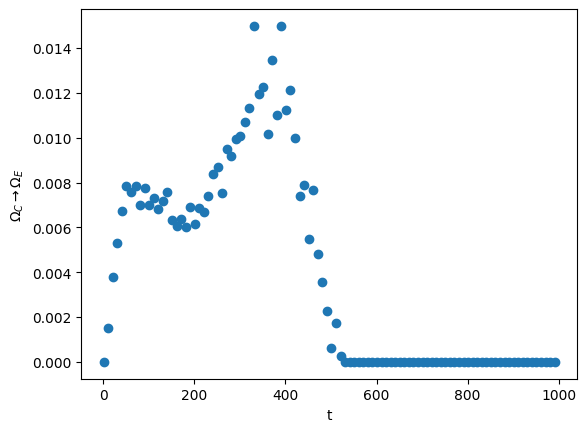

In [11]:
time_shifts = jnp.arange(1, 1000, 10)
losses = []

for t in tqdm(time_shifts):
    loss, _, _ = compute_causal_loss(
        cause=omega_2, 
        effect=omega_1,
        t=t
    )
    
    losses.append(loss)

plt.scatter(time_shifts, losses)
plt.xlabel('t')
plt.ylabel(r'$\Omega_C \rightarrow \Omega_E$');

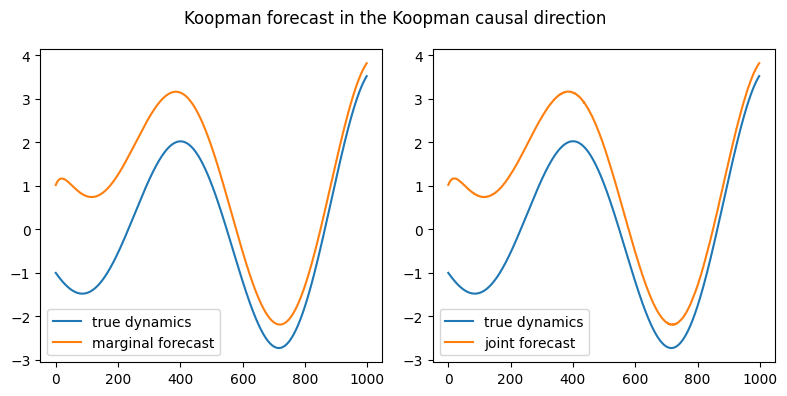

In [12]:
# Inference in the causal direction (assume shift of t=1)
_, omega_marginal, omega_joint = compute_causal_loss(
        cause=omega_2, 
        effect=omega_1,
        t=1
)

# Plot (marginal and joint)
f, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(omega_C[0], label='true dynamics')
ax[0].plot(omega_marginal[0], label='marginal forecast')
ax[0].legend()

ax[1].plot(omega_C[0], label='true dynamics')
ax[1].plot(omega_joint[0], label='joint forecast')
ax[1].legend()

f.suptitle('Koopman forecast in the Koopman causal direction')
plt.tight_layout()
plt.show();

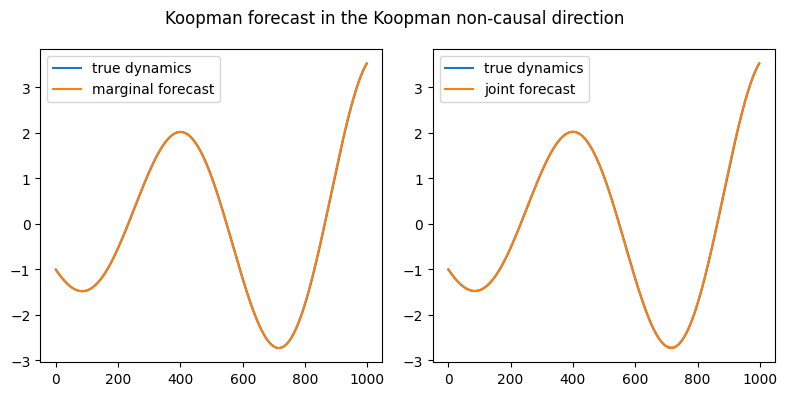

In [13]:
# Inference in the non-causal direction (assume shift of t=1)
_, omega_marginal, omega_joint = compute_causal_loss(
        cause=omega_1, 
        effect=omega_2,
        t=1
)

# Plot (marginal and joint)
f, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(omega_C[0], label='true dynamics')
ax[0].plot(omega_marginal[0], label='marginal forecast')
ax[0].legend()

ax[1].plot(omega_C[0], label='true dynamics')
ax[1].plot(omega_joint[0], label='joint forecast')
ax[1].legend()

f.suptitle('Koopman forecast in the Koopman non-causal direction')
plt.tight_layout()
plt.show();